In [1]:
using DelimitedFiles, Plots

In [2]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [3]:
using CUDA
CUDA.device!(0)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


CuDevice(0): TITAN RTX

In [4]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm")
muext = 0.00
muint = 2.50;

### choose family

In [5]:
fam = "PF00684"

open("/home/louise/MSA/Data/test/PF00684/")
L = 67; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [6]:
#fam = "PF00397"

#open("/home/louise/MSA/Data/test/PF00397/")
#L = 31; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

#delta = 5;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
#M = length(al)

#using DelimitedFiles
#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
#lambda_o = Lambda_all[1,:];
#lambda_e = Lambda_all[2,:];

### load results

In [7]:
function extract_data(namefile::String)
    data = readdlm(namefile);
    #np = 14
    param = data[1,:] #param = data[1,1:np]
    nsamp =param[1]

    inds = data[2,1:nsamp];
    res = data[3:end,:];

    xnsols = fill((0,0), L, nsamp)
    for ns in 1:nsamp
        for i=1:L
            x = res[ns,i]
            n = res[ns,L+i]
            xnsols[i,ns] = (x,n)
        end
    end

    sats = []
    ens = []
    for (i, idx0) in pairs(inds)
    #    @show i, idx0
        seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
        N = length(al[idx0][2])
        pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

        c = BpAlignGpu.check_sr!(xnsols[:,i], L, N)

        seqsol = BpAlignGpu.convert_soltosequence!(xnsols[:,i], seq.strseq, N, L)
        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        append!(sats, sum(c))
        append!(ens, energy)
    end
    return param, inds, sats, ens, xnsols
end


extract_data (generic function with 1 method)

In [60]:
path = "data_GS_solutions/"

"data_GS_solutions/"

In [61]:
nsamples = "60"

method = "mf"
decim = "maxP"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param_mf_maxP, inds_mf_maxP, sats_mf_maxP, ens_mf_maxP, xnsols_mf_maxP = extract_data(namefile);

In [62]:
method = "mf"
decim = "nucleation"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param_mf_nucleation, inds_mf_nucleation, sats_mf_nucleation, ens_mf_nucleation, xnsols_mf_nucleation = extract_data(namefile);

In [63]:
method = "mf"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param_mf_viterbi, inds_mf_viterbi, sats_mf_viterbi, ens_mf_viterbi, xnsols_mf_viterbi = extract_data(namefile);

In [64]:
method = "sce"
decim = "maxP"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param_sce_maxP, inds_sce_maxP, sats_sce_maxP, ens_sce_maxP, xnsols_sce_maxP = extract_data(namefile);

In [65]:
nsamples = "8"
method = "sce"
decim = "maxP"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p5.txt"
param2_d, inds2_d, sats2_d, ens2_d, xnsols2_d = extract_data(namefile);

j=0
for i in inds_sce_maxP
    if i in inds2_d
        j += 1
        sats_sce_maxP[i] = sats2_d[j]
        ens_sce_maxP[i] = ens2_d[j]
        xnsols_sce_maxP[:,i] = xnsols2_d[:,j]
    end
end

In [66]:
nsamples = "60"

method = "sce"
decim = "nucleation"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param_sce_nucleation, inds_sce_nucleation, sats_sce_nucleation, ens_sce_nucleation, xnsols_sce_nucleation = extract_data(namefile);


In [67]:
nsamples = "8"
method = "sce"
decim = "nucleation"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p5.txt"
param2_d, inds2_d, sats2_d, ens2_d, xnsols2_d = extract_data(namefile);

j=0
for i in inds_sce_maxP
    if i in inds2_d
        j += 1
        sats_sce_nucleation[i] = sats2_d[j]
        ens_sce_nucleation[i] = ens2_d[j]
        xnsols_sce_nucleation[:,i] = xnsols2_d[:,j]
    end
end

In [68]:
nsamples = "60"

method = "sce"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param_sce_viterbi, inds_sce_viterbi, sats_sce_viterbi, ens_sce_viterbi, xnsols_sce_viterbi = extract_data(namefile);

In [69]:
nsamples = "8"
method = "sce"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p5.txt"
param2_d, inds2_d, sats2_d, ens2_d, xnsols2_d = extract_data(namefile);

j=0
for i in inds_sce_maxP
    if i in inds2_d
        j += 1
        sats_sce_viterbi[i] = sats2_d[j]
        ens_sce_viterbi[i] = ens2_d[j]
        xnsols_sce_viterbi[:,i] = xnsols2_d[:,j]
    end
end

In [70]:
inds = inds_mf_maxP;

In [71]:
#inds |> unique

In [38]:
ens_hhmer = []
for (i, idx0) in pairs(inds)
#    @show i, idx0
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    seqsol = al[idx0][4]
    energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol, pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
#    @show energy
    append!(ens_hhmer, energy)
end
[ens_hhmer]

1-element Vector{Vector{Any}}:
 [-136.10445f0, -142.8652f0, -124.42836f0, -164.48659f0, -134.47443f0, -122.74458f0, -147.7068f0, -176.14442f0, -174.7197f0, -139.60654f0  …  -135.34436f0, -167.25708f0, -157.96045f0, -164.49744f0, -139.92998f0, -150.53888f0, -102.19451f0, -166.65474f0, -157.31967f0, -68.56604f0]

In [40]:
# DCAlign results:
nsamples = "60"

namefile2 = path * "run_GS_"*fam*"_n"*nsamples*"_DCAlign.txt"
res_GS_DCA = readdlm(namefile2);

sats_DCA = []
match_mf_DCA = []
ens_DCA = []
for (i, idx0) in pairs(inds)
#    @show i, idx0
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    seqsol = (String(res_GS_DCA[i,2]), String(res_GS_DCA[i,3]), res_GS_DCA[i,4], res_GS_DCA[i,5])
    energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    
    seqsol_mf = BpAlignGpu.convert_soltosequence!(xnsols_mf_maxP[:,i], seq.strseq, N, L)
    match = (seqsol == seqsol_mf)

    sat = res_GS_DCA[i,6]

#    @show energy, match, sat
    
    
    append!(sats_DCA, sat)
    append!(match_mf_DCA, match)
    append!(ens_DCA, energy)
end


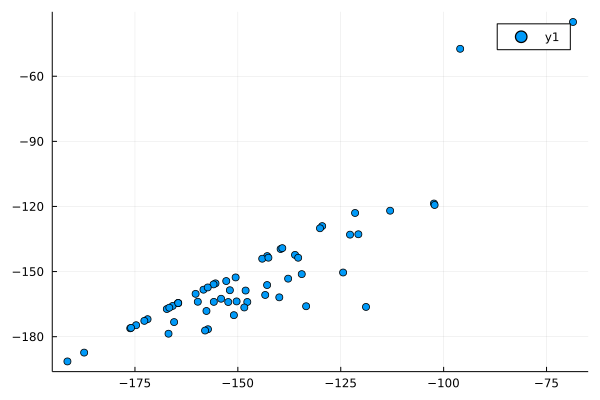

In [72]:
#scatter(ens_DCA, ens_mf_nucleation)
scatter(ens_hhmer, ens_sce_viterbi)

### Questions to ask
* solutions are SAT ?
* Sols found with mf are equal to sols found by DCAlign ??
* Compare energies hhmer/DCAlign/mf/sce
* compare energies obtained with different decimations
* do all these comparisons for several families


### Solutions are SAT ?

In [73]:
Nsats_mf_maxP = sum(sats_mf_maxP .!= 0)
Nsats_sce_maxP = sum(sats_sce_maxP .!= 0)
Nsats_DCAlign = sum(sats_DCA .== false)
Nsats_mf_maxP, Nsats_sce_maxP, Nsats_DCAlign

(7, 22, 5)

### Match DCAlign - mf

In [74]:
sum(match_mf_DCA)

49

### Compare decimations (on mf)

In [75]:
indssat_mf = findall(sats_mf_maxP .== 0)
x1 = sum(ens_mf_viterbi[indssat_mf] .<  ens_mf_maxP[indssat_mf])
x2 = sum(ens_mf_viterbi[indssat_mf] .==  ens_mf_maxP[indssat_mf])
x3 = sum(ens_mf_viterbi[indssat_mf] .>  ens_mf_maxP[indssat_mf])
(x1, x2, x3)

(5, 48, 0)

In [76]:
x1 = sum(ens_mf_nucleation[indssat_mf] .<  ens_mf_maxP[indssat_mf])
x2 = sum(ens_mf_nucleation[indssat_mf] .==  ens_mf_maxP[indssat_mf])
x3 = sum(ens_mf_nucleation[indssat_mf] .>  ens_mf_maxP[indssat_mf])
(x1, x2, x3)

(0, 53, 0)

In [77]:
x1 = sum(ens_mf_viterbi .<  ens_mf_nucleation)
x2 = sum(ens_mf_viterbi .==  ens_mf_nucleation)
x3 = sum(ens_mf_viterbi .>  ens_mf_nucleation)
(x1, x2, x3)

(8, 51, 1)

In [78]:
findall(ens_mf_viterbi .>  ens_mf_nucleation)

1-element Vector{Int64}:
 60

### Compare decimations (on sce) 

In [79]:
indssat_sce = findall(sats_sce_maxP .== 0)
x1 = sum(ens_sce_viterbi[indssat_sce] .<  ens_sce_maxP[indssat_sce])
x2 = sum(ens_sce_viterbi[indssat_sce] .==  ens_sce_maxP[indssat_sce])
x3 = sum(ens_sce_viterbi[indssat_sce] .>  ens_sce_maxP[indssat_sce])
(x1, x2, x3)

(7, 31, 0)

In [80]:
indssat_sce = findall(sats_sce_maxP .== 0)
x1 = sum(ens_sce_nucleation[indssat_sce] .<  ens_sce_maxP[indssat_sce])
x2 = sum(ens_sce_nucleation[indssat_sce] .==  ens_sce_maxP[indssat_sce])
x3 = sum(ens_sce_nucleation[indssat_sce] .>  ens_sce_maxP[indssat_sce])
(x1, x2, x3)

(0, 38, 0)

In [81]:
x1 = sum(ens_sce_viterbi .<  ens_sce_nucleation)
x2 = sum(ens_sce_viterbi .==  ens_sce_nucleation)
x3 = sum(ens_sce_viterbi .>  ens_sce_nucleation)
(x1, x2, x3)

(21, 38, 1)

In [82]:
findall(ens_sce_viterbi .>  ens_sce_nucleation)

1-element Vector{Int64}:
 48

### compare with hhmer

In [83]:
x1 = sum(ens_mf_viterbi .<  ens_hhmer)
x2 = sum(ens_mf_viterbi .==  ens_hhmer)
x3 = sum(ens_mf_viterbi .>  ens_hhmer)
(x1, x2, x3)

(37, 22, 1)

In [84]:
x1 = sum(ens_sce_viterbi .<  ens_hhmer)
x2 = sum(ens_sce_viterbi .==  ens_hhmer)
x3 = sum(ens_sce_viterbi .>  ens_hhmer)
(x1, x2, x3)

(34, 23, 3)

In [85]:
findall(ens_sce_viterbi .>  ens_hhmer)

3-element Vector{Int64}:
 24
 48
 60

### compare sce and mf

In [86]:
x1 = sum(ens_sce_viterbi .<  ens_mf_viterbi)
x2 = sum(ens_sce_viterbi .==  ens_mf_viterbi)
x3 = sum(ens_sce_viterbi .>  ens_mf_viterbi)
(x1, x2, x3)

(0, 55, 5)

In [87]:
indstocheck = findall(ens_sce_viterbi .>  ens_mf_viterbi)

5-element Vector{Int64}:
 48
 50
 56
 57
 60